In [2]:
pip install tensorflow


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Lambda, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


In [7]:
# Sampling layer for the VAE
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [8]:
# Encoder for the VAE
latent_dim = 2  # Dimension of the latent space
input_img = Input(shape=(28, 28, 1))
x = Flatten()(input_img)
x = Dense(128, activation='relu')(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(input_img, [z_mean, z_log_var, z], name="encoder")


In [9]:
# Decoder for the VAE
latent_inputs = Input(shape=(latent_dim,))
x = Dense(128, activation='relu')(latent_inputs)
x = Dense(28 * 28, activation='sigmoid')(x)
output_img = Reshape((28, 28, 1))(x)
decoder = Model(latent_inputs, output_img, name="decoder")


In [21]:
# Define VAE loss function
def vae_loss(input_img, output_img, z_mean, z_log_var):
    # Reconstruction loss
    reconstruction_loss = tf.reduce_sum(
        binary_crossentropy(tf.keras.layers.Flatten()(input_img),
                            tf.keras.layers.Flatten()(output_img)), axis=-1
    ) * 28 * 28
    # KL divergence loss
    kl_loss = -0.5 * tf.reduce_sum(
        1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1
    )
    return tf.reduce_mean(reconstruction_loss + kl_loss)

# Compile the VAE model with a custom loss
vae.compile(optimizer='adam', loss=lambda x, y: vae_loss(input_img, output_img, z_mean, z_log_var))



In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.losses import binary_crossentropy

# Load MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))

# Define VAE Encoder
def build_vae_encoder(latent_dim):
    inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Flatten()(inputs)
    x = layers.Dense(128, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    return models.Model(inputs, [z_mean, z_log_var], name="encoder")

# Define VAE Decoder
def build_vae_decoder(latent_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation='relu')(latent_inputs)
    x = layers.Dense(28 * 28, activation='sigmoid')(x)
    outputs = layers.Reshape((28, 28, 1))(x)
    return models.Model(latent_inputs, outputs, name="decoder")

# Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Build VAE
latent_dim = 2  # Example latent dimension
encoder = build_vae_encoder(latent_dim)
decoder = build_vae_decoder(latent_dim)

# Define the VAE model
inputs = layers.Input(shape=(28, 28, 1))
z_mean, z_log_var = encoder(inputs)
z = Sampling()([z_mean, z_log_var])
outputs = decoder(z)

vae = models.Model(inputs, outputs, name="vae")

# Custom VAE loss function
def vae_loss(input_img, output_img, z_mean, z_log_var):
    reconstruction_loss = tf.reduce_sum(
        binary_crossentropy(tf.keras.layers.Flatten()(input_img),
                            tf.keras.layers.Flatten()(output_img)), axis=-1
    ) * 28 * 28
    kl_loss = -0.5 * tf.reduce_sum(
        1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1
    )
    return tf.reduce_mean(reconstruction_loss + kl_loss)

# Custom training loop
optimizer = tf.keras.optimizers.Adam()

# Number of epochs and batch size
epochs = 10
batch_size = 64

# Training loop
for epoch in range(epochs):
    print(f'Starting epoch {epoch + 1}/{epochs}')
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i + batch_size]

        with tf.GradientTape() as tape:
            z_mean, z_log_var = encoder(x_batch)
            z = Sampling()([z_mean, z_log_var])
            reconstructed = decoder(z)
            loss = vae_loss(x_batch, reconstructed, z_mean, z_log_var)

        grads = tape.gradient(loss, vae.trainable_variables)
        optimizer.apply_gradients(zip(grads, vae.trainable_variables))

    print(f'Epoch {epoch + 1}/{epochs} - Loss: {loss.numpy():.4f}')

# Generate some images using the trained VAE
import matplotlib.pyplot as plt


def display_generated_images(decoder, n=10):
    # Generate random samples in the latent space
    z_sample = tf.random.normal(shape=(n, latent_dim))

    # Generate images from the sampled latent space
    generated_images = decoder(z_sample)

    # Reshape and plot the generated images
    generated_images = generated_images.numpy().reshape(n, 28, 28)
    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(2, n//2, i + 1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
    plt.show()









Starting epoch 1/10
Epoch 1/10 - Loss: 5731.5508
Starting epoch 2/10
Epoch 2/10 - Loss: 5470.0801
Starting epoch 3/10
Epoch 3/10 - Loss: 5286.0361
Starting epoch 4/10
Epoch 4/10 - Loss: 5137.5557
Starting epoch 5/10
Epoch 5/10 - Loss: 5063.3135
Starting epoch 6/10
Epoch 6/10 - Loss: 5026.1318
Starting epoch 7/10
Epoch 7/10 - Loss: 4986.0576
Starting epoch 8/10
Epoch 8/10 - Loss: 4974.1279
Starting epoch 9/10
Epoch 9/10 - Loss: 4958.5083
Starting epoch 10/10
Epoch 10/10 - Loss: 4938.8047


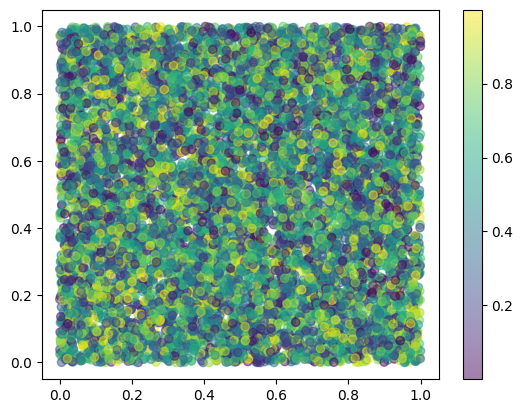

In [27]:

import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
n_points = 10000
x = np.random.rand(n_points)
y = np.random.rand(n_points)
colors = np.random.rand(n_points)  # Ensure this has the same number of elements

# Plotting
plt.scatter(x, y, c=colors, cmap='viridis', alpha=0.5)
plt.colorbar()  # Optional: add color bar for reference
plt.show()



In [28]:
print(f"x shape: {x.shape}, y shape: {y.shape}, colors shape: {colors.shape}")


x shape: (10000,), y shape: (10000,), colors shape: (10000,)


In [14]:
# Discriminator model for GAN
def build_discriminator():
    model = tf.keras.Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(128),
        LeakyReLU(alpha=0.2),
        Dense(64),
        LeakyReLU(alpha=0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

discriminator = build_discriminator()
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [13]:
# Generator model for GAN
def build_generator(latent_dim):
    model = tf.keras.Sequential([
        Dense(128, activation="relu", input_dim=latent_dim),
        Dense(784, activation="sigmoid"),
        Reshape((28, 28, 1))
    ])
    return model

latent_dim = 100
generator = build_generator(latent_dim)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Combined GAN model (generator + discriminator)
z = Input(shape=(latent_dim,))
img = generator(z)
discriminator.trainable = False
validity = discriminator(img)
gan = Model(z, validity)
gan.compile(optimizer='adam', loss='binary_crossentropy')


In [18]:
# Training the GAN
epochs = 1
batch_size = 5

for epoch in range(epochs):
    # Train discriminator
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_imgs = generator.predict(noise)

    real_y = np.ones((batch_size, 1))
    fake_y = np.zeros((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(real_imgs, real_y)
    d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_y)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    valid_y = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise, valid_y)

    # Display progress
    if epoch % 1 == 0:
        print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {1 * d_loss[1]}] [G loss: {g_loss}]")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
0 [D loss: 3.621504306793213 | D accuracy: 0.12268076837062836] [G loss: [array(3.621618, dtype=float32), array(3.621618, dtype=float32), array(0.1226774, dtype=float32)]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


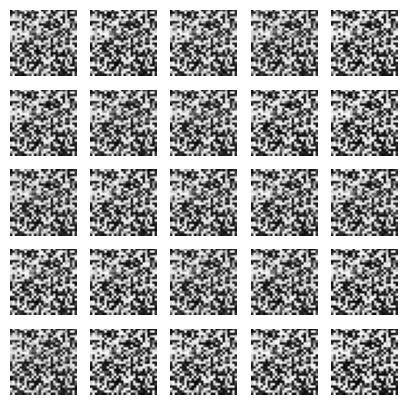

In [19]:
# Visualize generated images from GAN
noise = np.random.normal(0, 1, (25, latent_dim))
gen_imgs = generator.predict(noise)

plt.figure(figsize=(5, 5))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(gen_imgs[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()
